## 1. Data Loading and Initial Inspection


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

print("Train shape:", train.shape)
print("Features shape:", features.shape)
print("Stores shape:", stores.shape)


Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)


In [3]:
train.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

## 2. Time Series Preparation


In [6]:
train["Date"] = pd.to_datetime(train["Date"])


In [7]:
train = train.sort_values("Date")


In [8]:
weekly_sales = (
    train
    .groupby("Date", as_index=False)["Weekly_Sales"]
    .sum()
)


In [9]:
weekly_sales.set_index("Date", inplace=True)


In [10]:
weekly_sales.head()

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


## 3. Exploratory Time Series Analysis


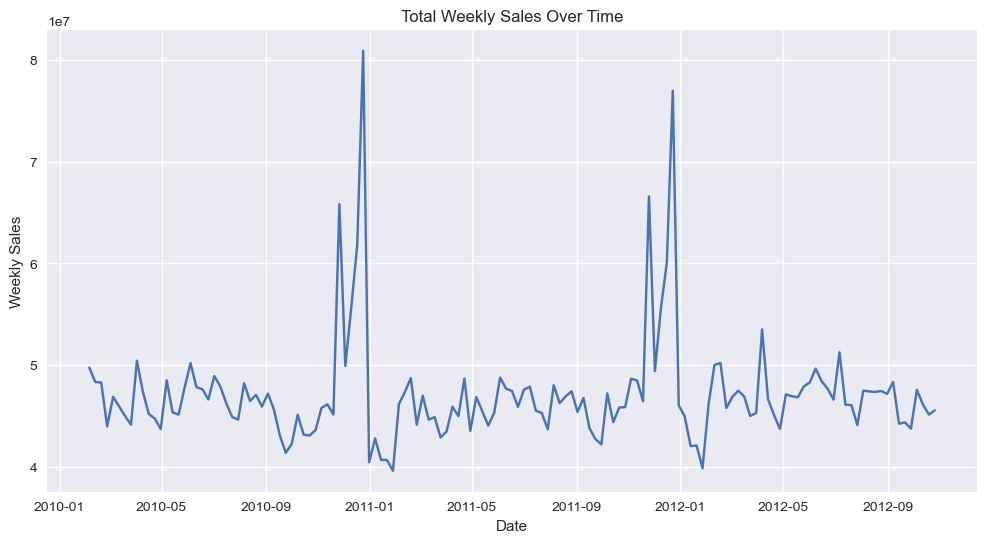

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index, weekly_sales["Weekly_Sales"])
plt.title("Total Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


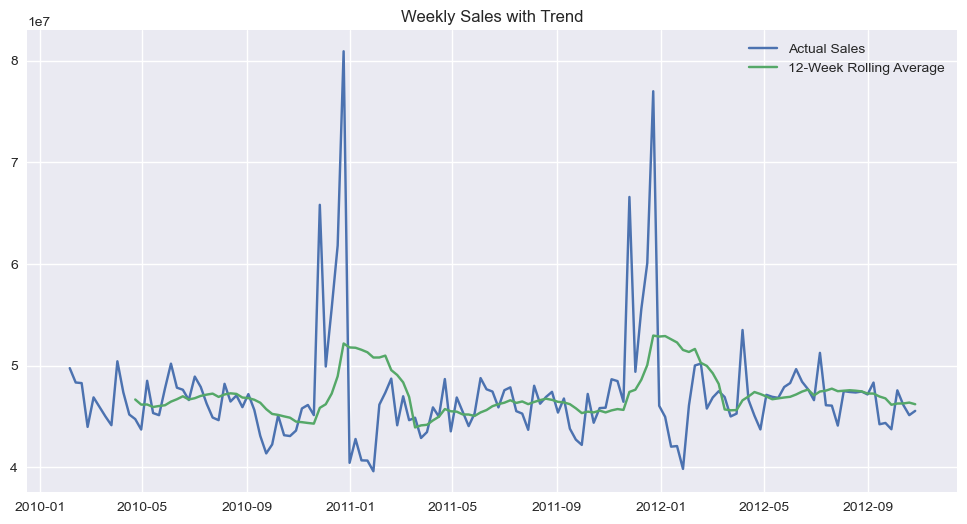

In [12]:
weekly_sales["Rolling_12"] = weekly_sales["Weekly_Sales"].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(weekly_sales["Weekly_Sales"], label="Actual Sales")
plt.plot(weekly_sales["Rolling_12"], label="12-Week Rolling Average")
plt.legend()
plt.title("Weekly Sales with Trend")
plt.show()


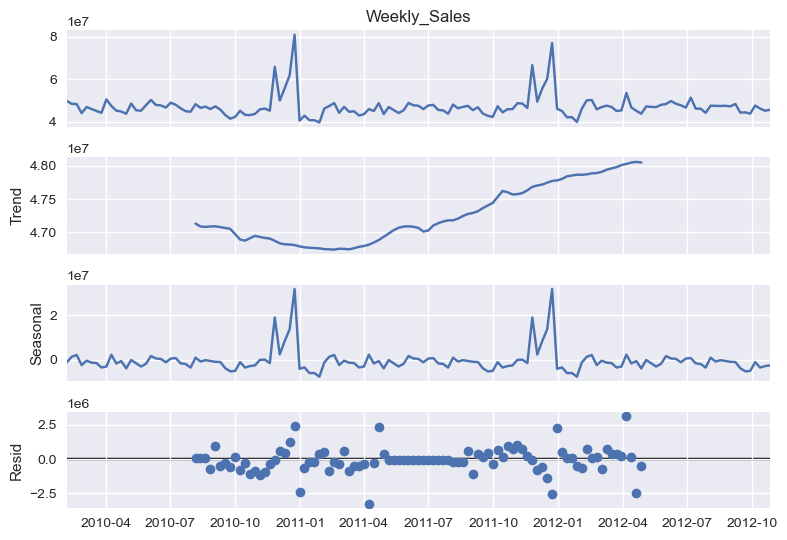

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    weekly_sales["Weekly_Sales"],
    model="additive",
    period=52
)

decomposition.plot()
plt.show()


## 4. Train-Test Split


In [14]:
split_index = int(len(weekly_sales) * 0.8)

train_ts = weekly_sales.iloc[:split_index]
test_ts = weekly_sales.iloc[split_index:]


In [15]:
print("Train size:", train_ts.shape)
print("Test size:", test_ts.shape)


Train size: (114, 2)
Test size: (29, 2)


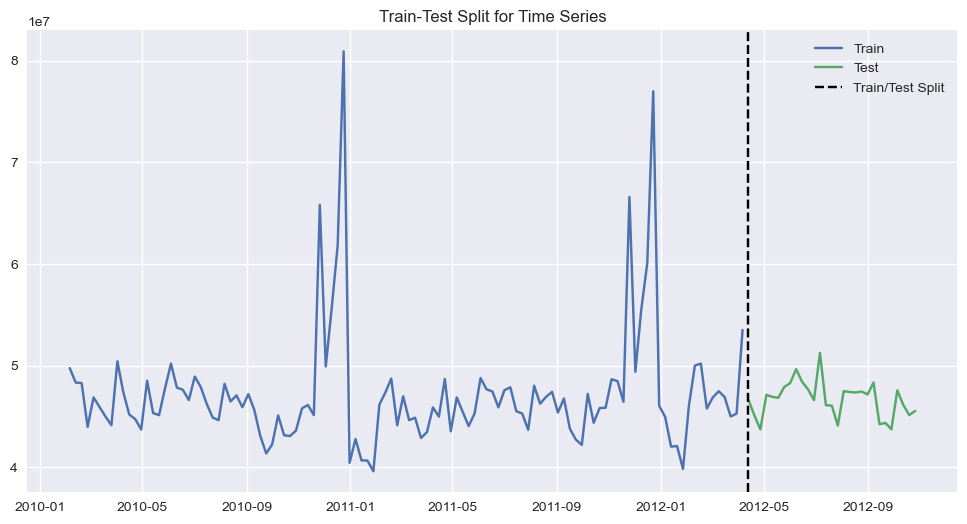

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts["Weekly_Sales"], label="Train")
plt.plot(test_ts.index, test_ts["Weekly_Sales"], label="Test")
plt.axvline(test_ts.index[0], color="black", linestyle="--", label="Train/Test Split")
plt.legend()
plt.title("Train-Test Split for Time Series")
plt.show()


## 5. Baseline Forecasting Models


In [17]:
naive_forecast = np.repeat(
    train_ts["Weekly_Sales"].iloc[-1],
    len(test_ts)
)

naive_forecast = pd.Series(
    naive_forecast,
    index=test_ts.index
)


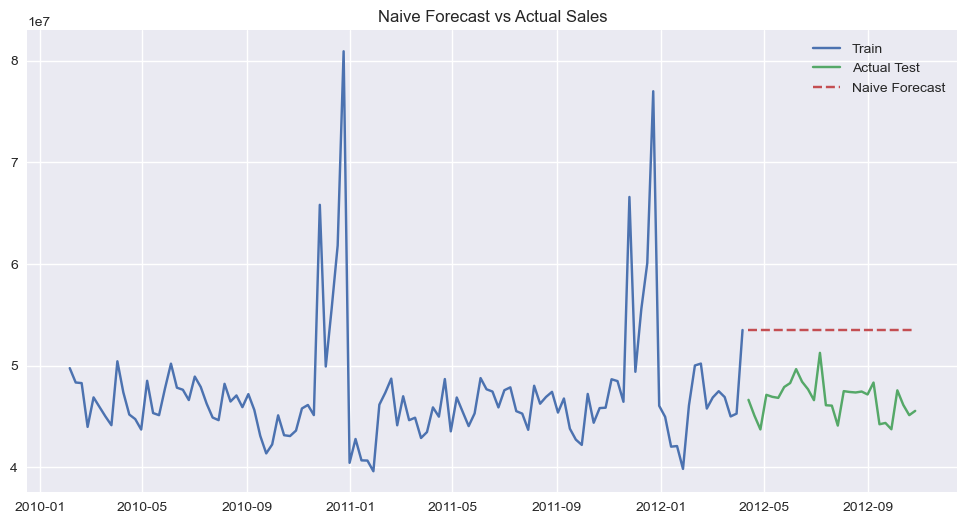

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts["Weekly_Sales"], label="Train")
plt.plot(test_ts.index, test_ts["Weekly_Sales"], label="Actual Test")
plt.plot(naive_forecast.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.legend()
plt.title("Naive Forecast vs Actual Sales")
plt.show()


In [19]:
moving_avg_value = train_ts["Weekly_Sales"].rolling(window=12).mean().iloc[-1]

ma_forecast = np.repeat(
    moving_avg_value,
    len(test_ts)
)

ma_forecast = pd.Series(
    ma_forecast,
    index=test_ts.index
)


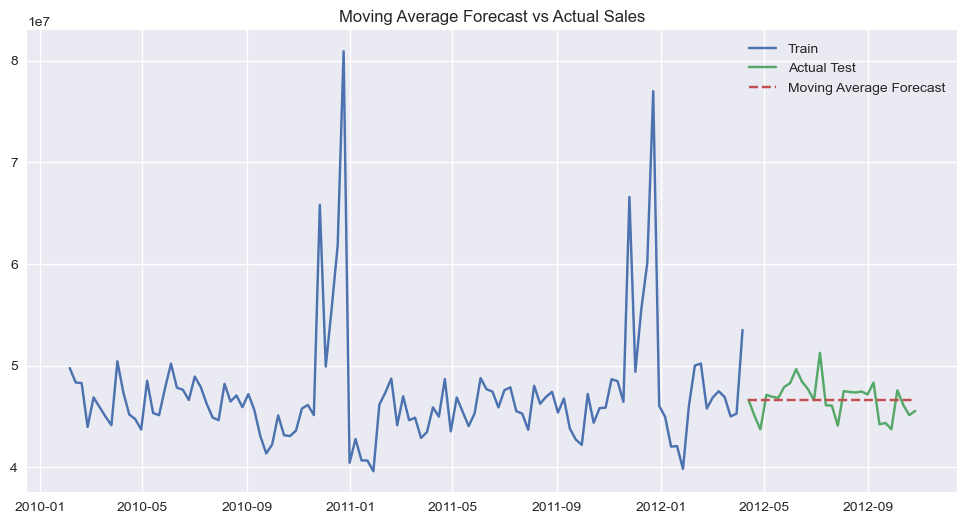

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts["Weekly_Sales"], label="Train")
plt.plot(test_ts.index, test_ts["Weekly_Sales"], label="Actual Test")
plt.plot(ma_forecast.index, ma_forecast, label="Moving Average Forecast", linestyle="--")
plt.legend()
plt.title("Moving Average Forecast vs Actual Sales")
plt.show()


## 6. Advanced Forecasting: SARIMA Model


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [22]:
# Seasonal order (P,D,Q,s): P=seasonal AR, D=seasonal diff, Q=seasonal MA, s=period
sarima_model = SARIMAX(
    train_ts["Weekly_Sales"],
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [23]:
sarima_forecast = sarima_fit.get_forecast(steps=len(test_ts))
sarima_pred = sarima_forecast.predicted_mean
sarima_conf = sarima_forecast.conf_int()


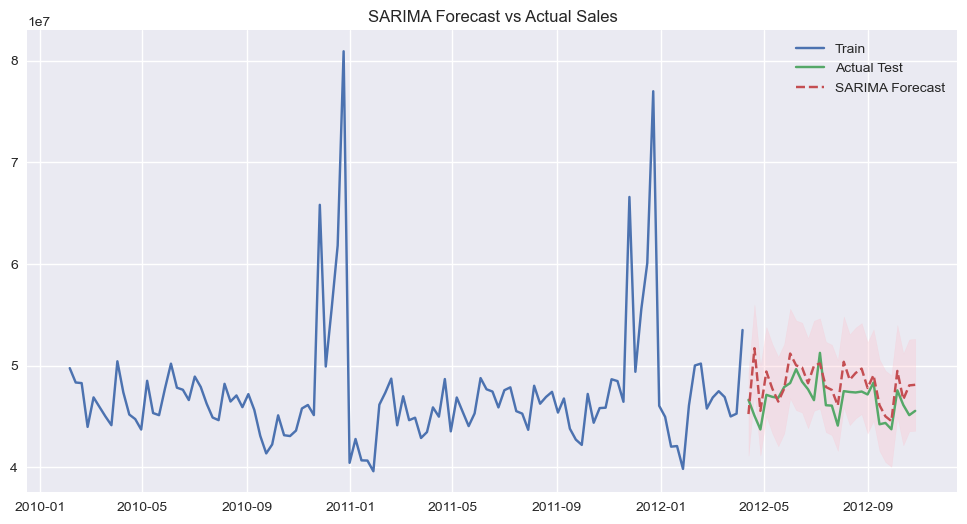

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts["Weekly_Sales"], label="Train")
plt.plot(test_ts.index, test_ts["Weekly_Sales"], label="Actual Test")
plt.plot(sarima_pred.index, sarima_pred, label="SARIMA Forecast", linestyle="--")
plt.fill_between(sarima_conf.index, sarima_conf.iloc[:,0], sarima_conf.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast vs Actual Sales")
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_ts["Weekly_Sales"], sarima_pred)
mae = mean_absolute_error(test_ts["Weekly_Sales"], sarima_pred)

print("SARIMA MSE:", mse)
print("SARIMA MAE:", mae)


SARIMA MSE: 4535838648456.017
SARIMA MAE: 1703732.9709031621


## 7. Business Insights & Recommendations


In [26]:
# Compare baselines vs SARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Naive
naive_mse = mean_squared_error(test_ts["Weekly_Sales"], naive_forecast)
naive_mae = mean_absolute_error(test_ts["Weekly_Sales"], naive_forecast)

# Moving Average
ma_mse = mean_squared_error(test_ts["Weekly_Sales"], ma_forecast)
ma_mae = mean_absolute_error(test_ts["Weekly_Sales"], ma_forecast)

# SARIMA already calculated as mse, mae
print("Baseline Comparison")
print(f"Naive - MSE: {naive_mse:.2f}, MAE: {naive_mae:.2f}")
print(f"Moving Avg - MSE: {ma_mse:.2f}, MAE: {ma_mae:.2f}")
print(f"SARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}")


Baseline Comparison
Naive - MSE: 49331393613701.75, MAE: 6807045.46
Moving Avg - MSE: 3008214338266.65, MAE: 1371444.34
SARIMA - MSE: 4535838648456.02, MAE: 1703732.97


### Key Insights

- Weekly sales show a **clear annual seasonality**, peaking during holidays.  
- Naive and moving average forecasts are **simple but not very accurate**.  
- SARIMA captures both trend and seasonality, giving **more reliable forecasts**.  
- Forecasts show expected spikes around holidays, which is critical for **inventory and staffing planning**.


### Business Recommendations

1. **Prepare inventory and staff ahead of seasonal peaks** based on SARIMA forecasts.  
2. **Monitor weekly sales trends** to detect sudden drops or unexpected spikes.  
3. **Use advanced forecasting models** like SARIMA for planning promotions and budgets.  
4. **Compare model performance regularly** to ensure forecasts remain accurate over time.
